<h1 align="center">Statistics for Machine Learning</h1>
<h2 align="center">k-Nearest Neighbors Classifier</h2>

&nbsp;

### Overview

Nearest neighbor methods are a set of machine learning algorithms that can be used to solve classification and regression problems. This notebook introduces the k-Nearest Neighbor method for classification, and builds a classifier from the ground up to solve the popular MNIST hand-written digit problem. The model is then expanded to accept any image outside of the training set, to test the accuracy of the model on digits beyond the MNIST collection.


### Contents

Section 1 - Overview of Nearest Neighbor Methods

Section 2 - Applying kNN to the MNIST Digit Dataset

Section 3 - Implementing a kNN Classifier

Section 4 - Pre-Processing and Using Custom Images

Section 5 - Conclusion

Section 6 - Glossary

Section 7 - Further Reading

### Imports

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from sklearn import datasets

<h2 align="center">Section 1 - Overview of Nearest Neighbor Methods</h2>

### 1.1 - Introduction to the Nearest Neighbors Approach

In the most simple of classification algorithms, a model could learn the entire training dataset and only make predictions if inputs exactly match the inputs that have already been seen. This approach of course has many issues, in that the training data cannot be expected to be comprehensive and include every possible input. Indeed the goal of machine learning is to generalise from training data and make predictions on unseen data. Instead a slightly more complex approach is to determine the value of an unseen input based on its similarity to inputs that have already been seen. This is the approach of **nearest neighbor** methods, where the training points that are most similar to the unseen input are called **neighbors**. An aggregation of the $k$ nearest neighbors can be used to determine the predicted target for an input value, where $k$ is a number chosen by the user. Generally, the modal target value of the nearest neighbors is chosen to solve classification tasks, and the mean is chosen to solve regression tasks. This general method is known as **k-Nearest Neighbors** (kNN), with the specific implementations for classification and regression known as **kNN Classifiers** and **kNN Regressors** respectively.

&nbsp;

### 1.2 - Representing Training Data as Points in Space

Nearest neighbor methods treat data as $n$-dimensional column vectors, where each feature is represented in a different dimension. For example, a very simple model could be built to classify people as having diabetes, or not having diabetes. The features for each sample person, $x_i$, could be: age, weight, and blood glucose. This corresponds to 3 features with each represented in a separate dimension, and so the result is a 3-dimensional column vector:

&nbsp;

$
x_1 =\begin{pmatrix}
   \text{age} \\
   \text{weight} \\
   \text{blood glucose}
\end{pmatrix}
=\begin{pmatrix}
   65\\
   86 \text{kg}\\
   130 \text{mg/dL}
\end{pmatrix}
$

&nbsp;

This can be shown graphically by assigning each feature to an axis and plotting the sample as a point in $n$-dimensional space, where $n$ is the number of input features. Since $n$ is 3 in this case, the point can be plot in 3-D space which is shown in the plot below. This simple example showed a training point with 3 features, but the idea can be extended to higher dimensions. Of course this cannot be visualised as below, but mathematically it is no more complex to plot a point in $n$-dimensional space.

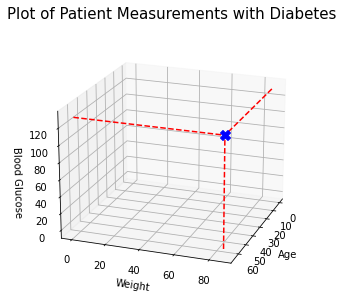

In [100]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(projection='3d')
ax.view_init(20,20)
ax.scatter(65, 86, 130, c='blue', s=100, marker='X')
ax.set_title('Plot of Patient Measurements with Diabetes', fontsize=15)

ax.set_xlabel('Age')
ax.set_ylabel('Weight')
ax.set_zlabel('Blood Glucose')

ax.plot([0,65],[86,86],[130,130], c='r', linestyle='--')
ax.plot([65,65],[0,86],[130,130], c='r', linestyle='--')
ax.plot([65,65],[86,86],[0,130], c='r', linestyle='--')

### 1.3 - Visualising Neighbors

Nearest neighbor methods use the idea that similar points will tend to cluster in $n$-dimensional space. In this example, this implies that patients with diabetes in general will tend to share similar features values such as blood glucose. Of course there will be differences, and maybe features such as age have less of an effect, but in general people with and without diabetes should show some separation in the feature space.

The plot below shows some points, where the blue dots represent patients who have diabetes and the red dots represent patients who do not have diabetes. The points show some separation, and so should be clear to see that if a new patient is introduced with an unknown diabetes status, a prediction can be made based on their similarity to other patients in the feature space. In this example, the unknown test point is marked in green.

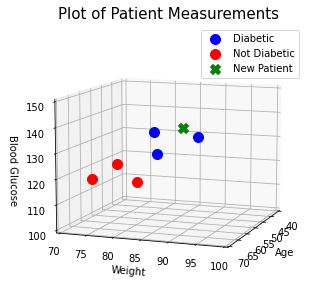

In [101]:
def plot_example(fig, ax):
    ax.view_init(10,20)
    ax.set_title('Plot of Patient Measurements', fontsize=15)

    ax.set_xlim(40, 70)
    ax.set_ylim(70, 100)
    ax.set_zlim(100, 150)

    ax.set_xlabel('Age')
    ax.set_ylabel('Weight')
    ax.set_zlabel('Blood Glucose')

    # Patients with diabetes
    ax.scatter(65, 86, 130, c='blue', s=100, marker='o', label='Diabetic')
    ax.scatter(61, 92, 136, c='blue', s=100, marker='o')
    ax.scatter(48, 79, 132, c='blue', s=100, marker='o')

    # Patients without diabetes
    ax.scatter(68, 75, 120, c='red', s=100, marker='o', label='Not Diabetic')
    ax.scatter(49, 72, 118, c='red', s=100, marker='o')
    ax.scatter(57, 79, 115, c='red', s=100, marker='o')

    # Patient with unknown diabetes status
    ax.scatter(63, 90, 140, c='green', s=100, marker='X', label='New Patient')

    ax.legend()
    

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection='3d')
plot_example(fig, ax)

### 1.4 - Determining the Nearest Neighbors

In the example above it is clear to see that the unknown point is surrounded by points representing patients with diabetes, and so it is a fair prediction to suggest this patient may also have diabetes. To determine this mathematically, some kind of distance metric is required. Once defined, the distance between each point and the test point can be calculated, and ranked in order from lowest (closest point) to highest (furthest point). In a classification task such as this, the labels associated with each point can then be examined. In this case, the top 3 closest points all have the label 'Diabetic' and so a kNN classifier with $k$=3 would classify this patient as diabetic. The region of the feature space enclosing the $k$ nearest neighbors is called the **neighborhood**.

There are a number of similarity metrics to quantify the distance between two points in $n$-dimensional space. These are referred to as *Minkowski* metrics, and are covered in detail in the notebook *k-Means Clustering*, which covers an unsupervised learning method closely related to kNN. In this notebook however, the commonly-used Euclidean distance metric is used. This states that the distance between two points is given by the length of a straight diagonal line through $n$-dimensional space that connects the two points. This is essentially an extension of Pythagorus' theorem in higher dimensions, and is given by:

&nbsp;

$\begin{align}
\text{d(a,b)} = \sqrt{\sum_{i=1}^{n} (a_i - b_i)^2} = \sqrt{(a_1-b_1)^2+(a_2-b_2)^2+...+(a_n-b_n)^2}
\end{align}$

&nbsp;

where $d$ is the distance function, and $a$ and $b$ are points in $n$-dimensional space. The plots below show the Euclidean distance between the point representing the new patient, and its three closest neighbors.


&nbsp;

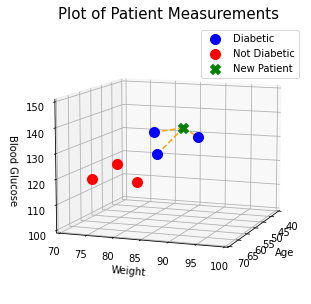

In [102]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection='3d')
plot_example(fig, ax)

for point in ([65, 86, 130], [61, 92, 136], [48, 79, 132]):
    x, y, z = point[0], point[1], point[2]
    ax.plot([63,x], [90,y], [140,z], linestyle='--', c='orange')

### 1.4 - kNN Classifer Algorithm

The kNN algorithm consists of only 4 steps, and is summarised below. These steps are applied later in this notebook to construct an implementation of a kNN classifer with Python. More on the algorithm itself can be found here [3].

1. Read in the training data. If 3 or less features are used, the points can be plot on a graph to aid with visualisation.
2. Select a distance metric (in this case Euclidean distance) and determine the distance between every training point and the test point.
3. Order the training points based on their distance to the test point from closest to furthest away.
4. Select a value for $k$, and find the modal label of the $k$ nearest neighbors. This is the prediction of the label for the test point.

&nbsp;

### 1.5 - Determining a Value for $k$

The number of nearest neighbors to use when determining a prediction for an unseen input, $k$, is user-chosen. The value must be selected carefully, since small values of $k$ will lead to unstable decision boundaries, and high values of $k$ may include points which are not representative of the test point. Another important consideration is whether $k$ is odd or even, since with an even value of $k$ the majority vote system of finding the modal value is possible to end in a draw. As a rule of thumb, $k$ can be chosen to be 5, or 10, but $k = \sqrt{n}$ is also used so that $k$ can scale with the size of the training set [1]. The plots below show values of $k$ which are too low, just right, and too high respectively. Another option is to trial multiple values of $k$ using a random subset of the data with cross-validation, and take the best-performing value of $k$ forward for the model.

&nbsp;

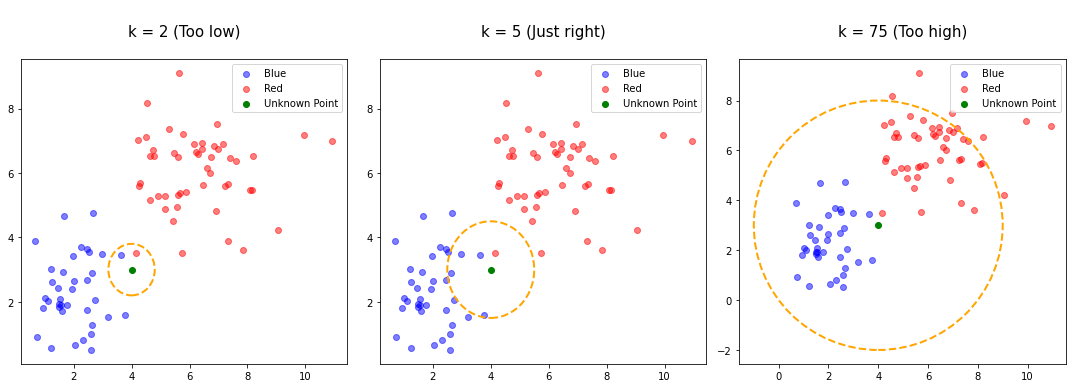

In [103]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5.5))

coords, labels = datasets.make_blobs(n_samples=100, centers=[(2,2),(6,6)], cluster_std=1.2, random_state=2)

blue = [coord for index, coord in enumerate(coords) if labels[index] == 0 and coord[0] > 0.5 and coord[1] > 0.5]
red = [coord for index, coord in enumerate(coords) if labels[index] == 1]
blue = np.asarray(blue)
red = np.asarray(red)

test_x, test_y = 4, 3

# Plot the scatter graph
for i in range(3):
    ax[i].scatter(blue.T[0],blue.T[1],color='b', label='Blue', alpha=0.5)
    ax[i].scatter(red.T[0],red.T[1],color='r', label='Red', alpha=0.5)
    ax[i].scatter(test_x, test_y, color='g', label='Unknown Point')
    ax[i].legend()

# Add neighborhoods
circle_small = plt.Circle((test_x, test_y), 0.8, color='orange', ls='--', lw=2, fc='None')
circle_medium = plt.Circle((test_x, test_y), 1.5, color='orange', ls='--', lw=2, fc='None')
circle_large = plt.Circle((test_x, test_y), 5, color='orange', ls='--', lw=2, fc='None')

ax[0].add_patch(circle_small)
ax[1].add_patch(circle_medium)
ax[2].add_patch(circle_large)

# Add titles
ax[0].set_title('\nk = 2 (Too low)\n', fontsize=15)
ax[1].set_title('\nk = 5 (Just right)\n', fontsize=15)
ax[2].set_title('\nk = 75 (Too high)\n', fontsize=15)

fig.tight_layout()

<h2 align="center">Section 2 - Applying kNN to the MNIST Digit Dataset</h2>

### 2.1 - Overview of the MNIST Dataset

To demonstrate the kNN model in action, this notebook applies the method to the MNIST hand-written digit dataset. This is a collection of 1797 images of the digits 0-9 written by hand, which have been scanned and reduced down to 8 x 8 grids of pixels. The task of the kNN model is to take in an image of a digit it has not been trained on, and classify the picture as a digit from 0-9, thus creating a simple hand-writing recognition model. The MNIST data can be downloaded online, or alternatively can be loaded directly from the `datasets` module in the SciKit Learn library [2] using the `load_digits` function. This returns a dictionary-like object called a Bunch, which has 7 keys- these can be seen in full below. The most useful of these here are `data` and `target`, which refer to the image data and corresponding labels respectively. More information about the dataset and its structure can be found using the `mnist.DESCR` method.

In [104]:
# Load the MNIST dataset from Sci-Kit Learn
digits = datasets.load_digits()

print(type(digits))

for key in digits:
    print(key)

<class 'sklearn.utils.Bunch'>
data
target
frame
feature_names
target_names
images
DESCR


### 2.2 - Structure of the Dataset

The dataset contains 1797 64x1 NumPy arrays, each representing a grid of 8 x 8 pixels. The value in each element corresponds to the brightness of a pixel, and is a float ranging from 0. (black), to 16. (white), with varying shades of grey in between. Below shows an example of one of these arrays, corresponding to the first image in the dataset.

In [105]:
# Extract the image arrays and labels
images = digits.data
labels = digits.target

# Print the first array and its corresponding label
print(f'Image Type: {type(images[0])}')
print(f'Element type: {type(images[0][0])}', end='\n\n')
print(images[0],end='\n\n')
print(f'Label: {labels[0]}')

Image Type: <class 'numpy.ndarray'>
Element type: <class 'numpy.float64'>

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]

Label: 0


### 2.3 - Displaying an Image

The `imshow` method in the Matplotlib library can be used to plot images based on pixel data. Here the first array has been plotted, with the `cm.gray_r` colour map. This inverts the colours, so that dark pixels are shown light and vice-versa. This gives an image we are more used to seeing: a white background with black text.

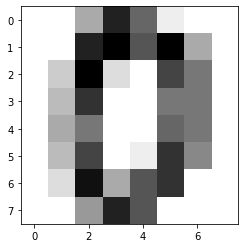

In [106]:
# Convert the data to and grid of 8x8 (could also load in the data pre-formatted using datasets.load-digits().images)
def plot_digit(digit):
    im = [digit[index:index+8] for index in range(0,len(digit),8)]
    plt.imshow(im,cmap=plt.cm.gray_r)

plot_digit(images[0])

### 2.4 - Pre-Processing the Data for Training

Before using the data in training, some pre-processing can be performed. The majority of the work has been covered by the developers of SciKit Learn, but one final step will aid in the implementation of the model for the purposes of this notebook. The `load_digits` function returns `images` and `labels` separately, but it would be useful to join these together in a series of tuples, so that each image and label are stored next to each other. To do this, built-in `zip` function can be used.

In [107]:
data = list(zip(images,labels))
print(data[0])

(array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.]), 0)


<h2 align="center">Section 3 - Implementing a kNN Classifier</h2>

### 3.1 - Note on Training vs Testing Data

When building a supervised learning model such as this it is important to divide the labelled data into two parts: one reserved for training and one reserved for testing. This allows the accuracy of the model to be assessed using data the model has not been trained on. This is an important point to note, and tests that the model is not simply relying on the information being shown beforehand, but is generalising a prediction function.

The cell below shows a function which takes in some labelled data as well as a test-train split ratio, in a similar fashion to the `test_train_split` function in SciKit Learn. This function divides the data into training data and testing data according to the `test_split` parameter, which is a float between 0 and 1 representing the percentage of data reserved for testing. Typical test-train split ratios are around 70:30, 75:25, or 80:20, for training data: testing data, however this can be experimented with and changed based on the application [4]. Later in this notebook the accuracy of the model is tested for several different test-train splits.

In [108]:
def train_test(test_split, data):
    test_size = int(len(data)*test_split)
    train_data, test_data = data[test_size:], data[:test_size]
    return train_data, test_data

# Split the data
train_data, test_data = train_test(0.20, data)

# Print the number of data points in each set
print(f'Images in training set: {len(train_data)}')
print(f'Images in testing set: {len(test_data)}')

# Check the sum of the two sets adds to the total in the dataset
print(f'Total images: {len(train_data)+len(test_data)}')

Images in training set: 1438
Images in testing set: 359
Total images: 1797


### 3.2 - Creating a Python Implementation of kNN

The cell below shows a Python implementation of the k-Nearest Neighbors method, which also includes a `plot_digit` method especially for working with the MNIST dataset. The class itself is generic and so can be applied to any supervised learning problem, using any data with any number of dimensions. There is also an `accuracy` function, which can be used to assess the accuracy of the model on the testing data.

In [109]:
from matplotlib import pyplot as plt

class kNN():

    ''' An implementation of the k-Nearest Neighbors method for use with MNIST digit data.

        Attributes:
            k (int):    The number of neighbors to use in the classification voting stage.
    '''

    def __init__(self, k=5):
        self.k = k

    def plot_digit(self, digit):
        ''' Display an array of 64 pixel brightness values as a black and white image.

            Args:
                digit (list-like): A 1 x 64 list-like object containing pixel values for brightness
                                   representing an 8 x 8 handwritten digit image.      

            Returns:
                None
        '''
        im = [digit[index:index+8] for index in range(0,len(digit),8)]
        plt.imshow(im,cmap=plt.cm.gray_r)
        plt.show()

    def euclidean(self, a, b):
        ''' Calculate the Euclidean distance between two points.

            Args:
                a (list):       The first point, written as a list of n elements representing the
                                coordinates in n-dimensional space.
                b (list):       The second point, with the same structure as a.

            Returns:
                dist (float):   The Euclidean distance between the points a and b.   
        '''
        dist = sum([(pair[0]-pair[1])**2 for pair in zip(a,b)])**0.5
        return dist

    def sorted_distances(self, point, data):
        ''' Find the distance between a point and each training point in order of closeness.

            Take in an unknown point as a list-like object containing coordinates, and a second
            list-like object containing list-likes of the coordinates for every training point.
            Calculate the Euclidean distance between the unknown point and every point in the
            training data. Store the distance between points and the label of the known point as a
            tuple in a list called distances, then sort the list by distance in descending order
            and return the list.

            Args:
                point (list-like):      An n-dimensional list representing the coordinates of a
                                        single unkown point in the feature space to be classified. 
                data (list-like):       The training data written as a list-like of list-likes,
                                        where each element represents a training data point in the
                                        same structure as point.

            Returns:
                distances (like-list):  A list-like of tuples containing the distance between a
                                        a point in the training dataset and the unkown point as the
                                        first element, and the label of the training point as the
                                        second element. The tuples are sorted in descending order
                                        by distance.  
        '''
        distances = [(self.euclidean(point, datum[0]), datum[1]) for datum in data]
        distances.sort(key=lambda x: x[0])
        return distances

    def mode(self, values):
        ''' Return the modal value in a list.

            Args:
                values (list-like):     The object to calculate the mode from. The structure is a
                                        list-like of tuples, where the first element is a float
                                        representing the distance between two points in Euclidean
                                        space, and the second is the label for the training point.

            Returns:
                modal_value (int/str):  The most common label present in values. Can be an integer
                                        or a string depending on the label assigned to the training
                                        points. 
        '''
        labels = [values[1] for values in values]
        modal_value = max(labels, key=labels.count)
        return modal_value

    def knn(self, point, data):
        ''' Classify an unknown point using the nearest neighbor method.

            Take in a point to be classified and calculate the distance between the point and every
            point in the training data. Sort the distances in descending order, and select the modal
            label from the k nearest points and assign this label to the point.

            Args:
                point (list-like):      An n-dimensional list representing the coordinates of a
                                        single unkown point in the feature space to be classified. 
                data (list-like):       The training data written as a list-like of list-likes,
                                        where each element represents a training data point in the
                                        same structure as point.

            Returns:
                modal_value (int/str):  The most common label present in the k closest points in the
                                        distances list. Can be an integer or a string depending on
                                        the label assigned to the training points. 
        '''
        distances = self.sorted_distances(point, data)
        modal_value = self.mode(distances[:self.k])
        return modal_value

    def train_test(self, test_split, data):
        '''
            Split the labelled data into a training set and test set according to a given ratio.

            Take in a float between 0 and 1 representing a fraction to split a list of known data
            points into two lists of testing data and training data. For example, a test_split value
            of 0.25 will reserve 75% of the data for training and 25% of the data for testing.

            Args:
                test_split (float):     A value between 0 and 1 specifying the percentage of data
                                        reserved for testing. 
                data (list-like):       The training data written as a list-like of list-likes,
                                        where each element represents a training data point in the
                                        same structure as point.

            Returns:
                train_data (list):      The fraction of the labelled data reserved for training. The
                                        structure consists of a list of list-likes,
                                        each representing an n-dimensional point in the feature
                                        space.
                test_data (list):       The fraction of the labelled data reserved for testing. The
                                        structure is the same as train_data.
        '''
        test_size = int(len(data)*test_split)
        train_data, test_data = data[test_size:], data[:test_size]
        return train_data, test_data

    def accuracy(self, test_split, data):
        '''
            Determine the accuracy of the model using a given test-train split ratio.

            Split the labelled data according to the test_split ration, and run the knn algorithm
            to classify each of the test points. Tally the number of correct predictions and divide
            by the number of predictions made to obtain the percentage accuracy.

            Args:
                test_split (float):     A value between 0 and 1 specifying the percentage of data
                                        reserved for testing. 
                data (list-like):       The training data written as a list-like of list-likes,
                                        where each element represents a training data point in the
                                        same structure as point.

            Returns:
                accuracy (float):       The percentage of correct classifications made by the model.
        '''
        train_data, test_data = self.train_test(test_split, data)

        success_count = 0
        for point in test_data:
            if self.knn(point[0], train_data) == point[1]:
                success_count += 1

        accuracy = (success_count/len(test_data)) * 100
        return accuracy

### 3.3 - Applying the Model to the MNIST Dataset

To apply the model to the MNIST data, an object of the `kNN` class must first be instantiated with a value of $k$. In this example, $k$ was chosen to be 11. Next, the `train_test` method can be used to divide the MNIST data since it is not split already. An alternative to this is to utilise the equivalent `test_train_split` function in SciKit Learn. A digit is then randomly selected from the testing dataset and drawn to the screen using the `plot_digit` method of the `kNN` class. The model is then probed to make a prediction based on the training data, which is then compared against the true label for the point. If the prediction matches the true label of the point then 'Correct' is printed to the screen. If not, 'Incorrect' is printed instead.

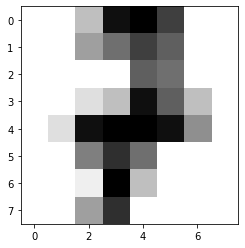

Predicted label: 7
True label: 7
Correct


In [110]:
model = kNN(k=11)
training_data, testing_data = model.train_test(0.75, data)

point = testing_data[random.randint(0,len(testing_data))]
model.plot_digit(point[0])
prediction = model.knn(point=point[0], data=training_data[1:])

print(f'Predicted label: {prediction}')
print(f'True label: {point[1]}')
print('Correct' if prediction == point[1] else 'Incorrect')

### 3.4 - Using Different Combinations of Hyperparameters

One way to find the optimum user-defined parameters (collectively called **hyperparameters**), is to use a range of combinations and measure the accuracies. In this case, the hyperparameters are *k* and the test-train split ratio, so different combinations of these values parameters can be used to determine the optimum configuration for the algorithm. The next step is to plot the accuracy for each combination, to try to identify any trends. This will help tune algorithm for future classifications.

As described earlier, some heuristics exist for determining a value for *k* (such as taking the square root of the size of the dataset). The cell below creates models with different values of $k$ between 10 and 50, and different test-train splits and finds the optimum combination for use with the MNIST dataset.

In [111]:
results = []

for k in [10,20,30,40,50]:
    for test_split in [0.20, 0.25, 0.30]:
        model = kNN(k=k)
        a = model.accuracy(test_split, data)
        results.append([a, k, test_split])

results.sort(key=lambda x: x[0], reverse=True)
tuned = results[0]
print(f'Optimum parameters: k = {tuned[1]}, test-train split = {100-round(tuned[2]*100)}:{round(tuned[2]*100)}')
print(f'Highest accuracy:{tuned[0]:.2f}%')

Optimum parameters: k = 10, test-train split = 70:30
Highest accuracy:94.81%


### 3.5 - Plotting the Accuracy Curves

Once the results have been collected, plots can be made to visualise the effect of *k* and the test-train split ratio on the accuracy of the algorithm over the testing data. The trends in these plots can be used to identify which hyperparameters values will give the best accuracy, without testing every possible combination of values. Below a function is defined that extracts results from the optimisation study above. This is used to create each of the lines in the plots.

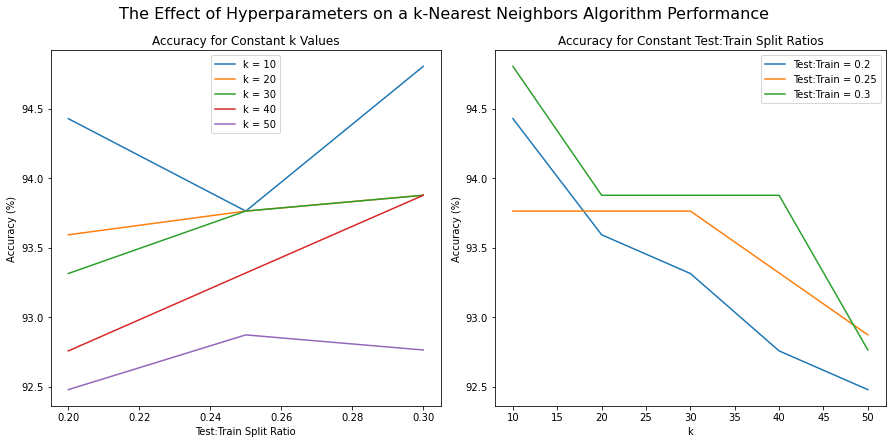

In [112]:
def get_results(k=None, split=None):

    if k is not None and split is None:
        output = [result for result in results if result[1] == k]
        output.sort(key=lambda x: x[2])
        output = [result[0] for result in output]
    
    elif split is not None and k is None:
        output = [result for result in results if result[2] == split]
        output.sort(key=lambda x: x[1])
        output = [result[0] for result in output]

    return output


fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(12.5)
fig.set_figheight(6.25)
fig.suptitle('The Effect of Hyperparameters on a k-Nearest Neighbors Algorithm Performance ', fontsize=16)

for k in [10, 20, 30, 40, 50]:
    ax[0].plot([0.20, 0.25, 0.30], get_results(k=k), label=f'k = {k}')

for split in [0.20, 0.25, 0.30]:
    ax[1].plot([10, 20, 30, 40, 50], get_results(split=split), label=f'Test:Train = {split}')

ax[0].set_title('Accuracy for Constant k Values')
ax[0].set_xlabel('Test:Train Split Ratio')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend()

ax[1].set_title('Accuracy for Constant Test:Train Split Ratios')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()

fig.tight_layout()


### 3.6 - Limitations of k-Nearest Neighbors

**Dataset Structure:**

k-Nearest Neighbors works well in certain scenarios, however the model suffers from lack of generalisations to 
different types of datasets. As an example, consider the classification problem below. The data contains two classes, shown in blue and red. An unknown point is introduced to the model (shown in green) which clearly does not fit into either class. In a higher dimension problem where this fact may not be obvious to the programmer, the model will be relied on to classify the point. Clearly the accuracy of the prediction here is questionable, though the model will report the same confidence as any other prediction.


**Large Datasets and Higher Dimensions:**

Nearest neighbor methods rely on calculating the distance between an unknown point and every point in the training dataset. As the size of the dataset increases, the performance of the algorithm can be expected to decrease, leading to longer computation times. This is in comparison to method which use gradient descent for example, which are robust to increasing dataset size. For the same reason, datasets with a high number of dimensions can also negatively impact performance.

**Sensitivity to $k$:**

kNN is highly sensitive to the value of $k$, which is not always an immediately obvious choice. This necessitates a degree of trial and error in order ot tune the model appropriately.

&nbsp;


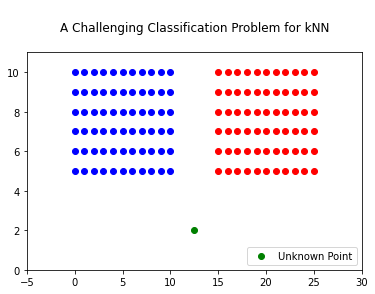

In [163]:
class_1 = [[(x, y) for y in [5, 6, 7, 8, 9, 10]] for x in range(11)]
class_2 = [[(x, y) for y in [5, 6, 7, 8, 9, 10]] for x in range(15, 26)]

fig, ax = plt.subplots()
ax.set_title('\nA Challenging Classification Problem for kNN\n')
ax.set_ylim(0, 11)
ax.set_xlim(-5, 30)

for sub_list in class_1:
    for point in sub_list:
        ax.scatter(point[0], point[1], c='blue')

for sub_list in class_2:
    for point in sub_list:
        ax.scatter(point[0], point[1], c='red')

ax.scatter(12.5, 2, c='green', label='Unknown Point')
ax.legend(loc='lower right')

<h2 align="center">Section 4 - Pre-Processing and Using Custom Images</h2>

### 4.1 - Converting Images to Greyscale 8x8 Grids

Now the `knn` function has been written and optimised, it can be tested on images not found in the dataset. The function below reads in every image in a directory called 'images' that is inside the same directory as this notebook. It then loops through each image, reads in the pixel values in greyscale, then resizes the image to a grid of 8x8 pixels. Preparing inputs in this way so that they can be used with an existing algorithm is known as **pre-processing**.

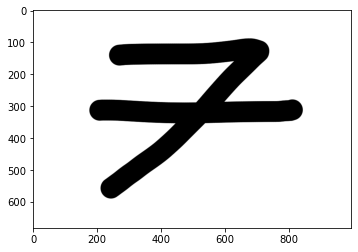

In [138]:
def convert_images_to_pixels(directory: str):
    parent_dir = os.getcwd()
    os.chdir(directory)
    converted_images = []

    for pic in os.listdir('.'):
        try:
            raw_image = Image.open(pic).convert('L')
            resized_image = raw_image.resize((8,8))
            image_data = [int(value/16) for value in list(resized_image.getdata())]
            converted_images.append(image_data)
        except:
            print(f"Unable to convert '{pic}'")
    os.chdir(parent_dir)
    return converted_images

number_7 = Image.open('number.png').convert('L')
plt.imshow(number_7, cmap=plt.cm.gray_r)

### 4.2 - Testing Custom Images

The data for each image in the 'images' directory (which currently only contains the number 7 picture shown above) is plotted using the `plot_digit` function written earlier. The image data is then fed into the `knn` function, which makes a prediction on what digit the image represents. Here, the function correctly classifies the image as a `7`.

Unable to convert '.DS_Store'
Prediction: 7


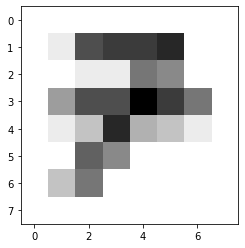

In [139]:
test_images = convert_images_to_pixels('.')

for test_image in test_images:
    plot_digit(test_image)
    #print(f'Prediction: {knn(2, test_image, data)}')
    print(f'Prediction: {model.knn(point=test_image, data=training_data[1:])}')

<h2 align="center">Section 5 - Conclusion</h2>

The k-Nearest Neighbors model can be used to solve classification and regression tasks. In this notebook, the kNN classifier model was introduced and applied to the MNIST hand written digit dataset to build a simple handwriting recognition model. Some key limitations of the model were discussed, such as the lack of robustness to increasing dataset size, and well as the sensitivity to the value of $k$ chosen for the model.

&nbsp;

<h2 align="center">Section 6 - Glossary</h2>

**k-Nearest Neighbors**
> A nearest neighbor method which classifies a point using the modal value of the surrounding $k$ neighbors, or determines the output for a regression problem by taking the arithmetic mean of the surround $k$ neighbors.

**kNN Classifier**
> The model produced when k-nearest neighbors is applied to a classification problem.

**kNN Regressor**
> The model produced when k-nearest neighbors is applied to a regression problem.

**Nearest Neighbor Methods**
> A group of machine learning methods which determine predictions based on the training points closest to the unknown point in the feature space.

**Neighbor**
> A point in the training space that is near to the unknown point.

**Neighborhood**
> The region of the feature space enclosing the $k$ nearest neighbors.

**Pre-Processing**
> Preparing inputs so they can be used with an existing model.

&nbsp;

<h2 align="center">Section 7 - Further Reading</h2>

[1] Selection of k - [VincentQin](https://vincentqin.gitee.io/blogresource-2/cv-books/8-kNN.pdf)

[2] Machine learning in Python - [Sci-Kit Learn](https://scikit-learn.org/stable/)

[3] Overview of the kNN algorithm - [Towards Data Science](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761)

[4] Test-train split ratios - [Baeldung](https://www.baeldung.com/cs/train-test-datasets-ratio#:~:text=If%20we%20search%20the%20Internet,even%20a%2050%3A50%20split.)